In [ ]:
!apt-get install -y xvfb python-opengl
!pip install gym pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,281 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 1,281 kB in 1s (1,116 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import cv2
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
import time

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
display = Display(visible=0, size=(400, 400))

In [ ]:
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(0)
        self.buffer_size = 2000
        self.batch_size = 64
        self.gamma = 0.99
        self.lr = 0.0025
        self.update_every = 4
        self.local = DQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=self.lr)
        self.memory = deque(maxlen=self.buffer_size)
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state',
                                                                'done'])
        self.t_step = 0
    def step(self, state, action, reward, next_state, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.sample_experiences()
                self.learn(experiences, self.gamma)

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        Q_expected = self.local(states).gather(1, actions)
        Q_targets_next = self.local(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def act(self, state, eps=0.):
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.local.eval()
            with torch.no_grad():
                action_values = self.local(state)
            self.local.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def sample_experiences(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return states, actions, rewards, next_states, dones

In [ ]:
display.start()
env = gym.make('CartPole-v1')
agent = Agent(env.observation_space.shape[0], env.action_space.n)

In [ ]:
scores = []
scores_window = deque(maxlen=100)
n_episodes = 5000
max_t = 5000
eps_start = 1.0
eps_end = 0.001
eps_decay = 0.9995
eps = eps_start

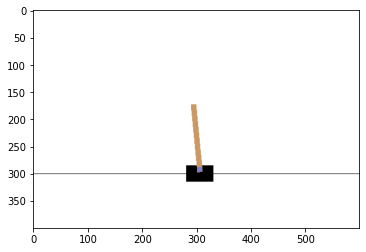

In [ ]:
for i_episode in range(1, n_episodes + 1):
    state = env.reset()
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)
    state_size = env.observation_space.shape[0]
    state = np.reshape(state, [1, state_size])
    score = 0

    for i in range(max_t):  
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        screen = env.render(mode='rgb_array')
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        next_state = np.reshape(next_state, [1, state_size])
        reward = reward if not done or score == 499 else -10
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    ipythondisplay.clear_output(wait=True)
    scores_window.append(score)
    scores.append(score)
    eps = max(eps_end, eps_decay * eps)
    time.sleep(2)
    print('\rEpisode: {}\tReward: {} \tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode, score, 
                                                                                   np.mean(scores_window), eps), 
          end='')
    if i_episode % 100 == 0:
        time.sleep(2)
        print('\rEpisode: {} \tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode, np.mean(scores_window), eps))
    if i_episode > 10 and np.mean(scores[-10:]) > 450:
        break


In [ ]:
plt.plot(scores)
plt.title('Scores over increasing episodes')
plt.show()

In [ ]:
env.close()

ERROR: Could not find a version that satisfies the requirement colorization (from versions: none)
ERROR: No matching distribution found for colorization
